<a href="https://colab.research.google.com/github/MADNESSru/NN_models/blob/main/(Cats%20vs%20Dogs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [190]:
# kaggle dataset - https://www.kaggle.com/datasets/d4rklucif3r/cat-and-dogs
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import torchvision as tv
import cv2
from google.colab import files
import zipfile

In [191]:
# pipline:
# Датасет
# Даталоадер
# Архетиктура
# optimizer, loss, metric
# train
# test

In [192]:
# кастомный датасет
class BinaryDataset(torch.utils.data.Dataset):
  def __init__(self, dir1:str, dir2:str):
    super().__init__()

    self.dir1 = dir1
    self.dir2 = dir2

    self.dir1_list = sorted([f for f in os.listdir(dir1)
     if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    self.dir2_list = sorted([f for f in os.listdir(dir2)
     if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    print(self.dir1, len(self.dir1_list))
    print(self.dir2, len(self.dir2_list))

  def __len__(self):
    return len(self.dir1_list) + len(self.dir2_list)

  def __getitem__(self, idx):
    if idx < len(self.dir1_list):
      class_id = 0
      img_path = os.path.join(self.dir1, self.dir1_list[idx])
    else:
      class_id = 1
      idx -= len(self.dir1_list)
      img_path = os.path.join(self.dir2, self.dir2_list[idx])

    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is None:
      raise ValueError(f'Нe удалось загрузить изображение {img_path}')

    if img.ndim != 3 or img.shape[2] != 3:
      raise ValueError(f'Изображение не имеет 3 каналов: {img_path}, shape: {img.shape}')

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    img = img/255.0 # нормализация
    img = cv2.resize(img, (50, 50), interpolation=cv2.INTER_AREA) # уменьшение
    img = img.transpose((2, 0, 1))
    t_img = torch.from_numpy(img).clone()
    t_class_id = torch.tensor(class_id)

    return {'img': t_img, 'label': t_class_id}

In [193]:
uploaded = files.upload()

Saving dogs.zip to dogs (1).zip


In [194]:
upload = files.upload()

Saving cats.zip to cats (1).zip


In [195]:
with zipfile.ZipFile('dogs.zip', 'r') as zipd_ref:
  zipd_ref.extractall('/content/dogs_train')
with zipfile.ZipFile('cats.zip', 'r') as zipc_ref:
  zipc_ref.extractall('/content/cats_train')

In [196]:
path_train_dogs = '/content/dogs_train/dogs'
path_train_cats = '/content/cats_train/cats'
train_ds_CatsDogs = BinaryDataset(path_train_dogs, path_train_cats)

/content/dogs_train/dogs 4000
/content/cats_train/cats 4000


In [197]:
with zipfile.ZipFile('dogs_t.zip', 'r') as ziph_ref:
  ziph_ref.extractall('/content/dogs_test')
with zipfile.ZipFile('cats_t.zip', 'r') as zipt_ref:
  zipt_ref.extractall('/content/cats_test')

In [198]:
path_test_dogs = '/content/dogs_test/dogs'
path_test_cats = '/content/cats_test/cats'
test_ds_CatsDogs = BinaryDataset(path_test_dogs, path_test_cats)

/content/dogs_test/dogs 1000
/content/cats_test/cats 1000


In [199]:
def debug_collate(batch):
      try:
          return torch.utils.data._utils.collate.default_collate(batch)
      except Exception as e:
          print("Ошибка при склейке батча!")
          for i, item in enumerate(batch):
              print(f"item {i}: shape={item['img'].shape}, label={item['label']}")
          raise e

In [200]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(
    train_ds_CatsDogs, batch_size=batch_size, shuffle=True, num_workers=0,
    drop_last=True, collate_fn=debug_collate
)
test_loader = torch.utils.data.DataLoader(
    test_ds_CatsDogs, batch_size=batch_size, shuffle=True, num_workers=0,
    drop_last=False
)

In [210]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.act = nn.LeakyReLU(0.2)
    self.maxpool = nn.MaxPool2d(2, 2)
    self.conv0 = nn.Conv2d(3, 32, 3, stride=1, padding=0)
    self.conv1 = nn.Conv2d(32, 32, 3, stride=1, padding=0)
    self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=0)
    self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=0)

    self.adaptivepool = nn.AdaptiveAvgPool2d((1, 1))
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(128, 20)
    self.linear2 = nn.Linear(20, 2)

  def forward(self, x):

    out = self.conv0(x)
    out = self.act(out)
    out = self.maxpool(out)

    out = self.conv1(out)
    out = self.act(out)
    out = self.maxpool(out)

    out = self.conv2(out)
    out = self.act(out)
    out = self.maxpool(out)

    out = self.conv3(out)
    out = self.act(out)

    out = self.adaptivepool(out)
    out = self.flatten(out)
    out = self.linear1(out)
    out = self.act(out)
    out = self.linear2(out)

    return out

In [211]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [212]:
model = ConvNet()
model

ConvNet(
  (act): LeakyReLU(negative_slope=0.2)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (adaptivepool): AdaptiveAvgPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=128, out_features=20, bias=True)
  (linear2): Linear(in_features=20, out_features=2, bias=True)
)

In [213]:
count_parameters(model)

105118

In [214]:
for sample in train_loader:
  img = sample['img']
  label = sample['label']
  model(img)
  break

In [215]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999))

In [216]:
def accuracy(pred, label):
  results = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
  return results.mean()

In [217]:
epochs = 10 # шагов обновления весов
for epochs in range(epochs):
  loss_val = 0 # суммарная потеря за шаг
  acc_val = 0 # суммарная точность за шаг
  for sample in (pbar := tqdm(train_loader)): # цикл по батчам в датасете
    img, label = sample['img'], sample['label']
    optimizer.zero_grad() # обновление градиентов

    label = F.one_hot(label, 2).float() # для сравнения с истинными метками
    pred = model(img)

    loss = loss_fn(pred, label) # вычисление ошибки

    loss.backward() # градиенты для обновления параметров
    loss_item = loss.item() #
    loss_val += loss_item

    acc_current = accuracy(pred, label)
    acc_val += acc_current

    optimizer.step() # обновление параметров на основе градиентов

    # прогресс-бар
    pbar.set_description(f'loss: {loss_item:.5f}; accuracy: {acc_current:.3f}')
  print(loss_val/len(train_loader))
  print(acc_val/len(train_loader))

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-216-e6f37deda7a4>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  results = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
loss: 0.68414; accuracy: 0.625: 100%|██████████| 500/500 [00:42<00:00, 11.73it/s]


0.6923260134458542
0.5245


loss: 0.57227; accuracy: 0.625: 100%|██████████| 500/500 [00:41<00:00, 11.94it/s]


0.6530750818252563
0.619875


loss: 0.63049; accuracy: 0.750: 100%|██████████| 500/500 [00:41<00:00, 11.95it/s]


0.5874417096972465
0.693875


loss: 0.18171; accuracy: 0.938: 100%|██████████| 500/500 [00:42<00:00, 11.74it/s]


0.5137204982340335
0.75


loss: 0.42329; accuracy: 0.875: 100%|██████████| 500/500 [00:42<00:00, 11.85it/s]


0.4638312822580338
0.782


loss: 0.32024; accuracy: 0.875: 100%|██████████| 500/500 [00:41<00:00, 11.96it/s]


0.4223337909281254
0.804


loss: 0.23723; accuracy: 0.938: 100%|██████████| 500/500 [00:41<00:00, 11.93it/s]


0.39013537949323657
0.81925


loss: 0.40080; accuracy: 0.750: 100%|██████████| 500/500 [00:42<00:00, 11.71it/s]


0.3502116410136223
0.846


loss: 0.62379; accuracy: 0.750: 100%|██████████| 500/500 [00:41<00:00, 11.97it/s]


0.31954106982052327
0.85875


loss: 0.16676; accuracy: 0.938: 100%|██████████| 500/500 [00:41<00:00, 11.91it/s]

0.2734578034952283
0.882


In [218]:
loss_val = 0 # суммарная потеря за шаг
acc_val = 0 # суммарная точность за шаг
for sample in (pbar := tqdm(test_loader)): # цикл по батчам в датасете
  with torch.no_grad():
    img, label = sample['img'], sample['label']

    label = F.one_hot(label, 2).float() # для сравнения с истинными метками
    pred = model(img)

    loss = loss_fn(pred, label) # вычисление ошибки
    loss_item = loss.item() #
    loss_val += loss_item

    acc_current = accuracy(pred, label)
    acc_val += acc_current

  # прогресс-бар
  pbar.set_description(f'loss: {loss_item:.5f}; accuracy: {acc_current:.3f}')
print(loss_val/len(test_loader))
print(acc_val/len(test_loader))

  0%|          | 0/125 [00:00<?, ?it/s]<ipython-input-216-e6f37deda7a4>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  results = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
loss: 0.49462; accuracy: 0.750: 100%|██████████| 125/125 [00:08<00:00, 15.17it/s]

0.5160608054995537
0.794


**ПРОВЕРКА НА КАРТИНКАХ ИЗ ИНЕТА И СВОИХ ДОМАШНИХ ЗВЕРЯХ**

In [297]:
image_path_1 = '/content/sobaka_Vlada.jpg'
image_path_2 = '/content/Kot_Meme.jpg'
image_path_3 = '/content/Kot_is_ineta.jpg'
image_path_4 = '/content/cot_evi_1.jpg'
image_path_5 = '/content/cot_evi_2.jpg'
image_path_6 = '/content/cot_evi_3.jpg'

In [298]:
def predict_image(img_path, model):
  img_bgr = cv2.imread(img_path)
  img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
  img = cv2.imread(img_path, cv2.IMREAD_COLOR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img.astype(np.float32)/255.0
  img = cv2.resize(img, (50, 50), interpolation=cv2.INTER_AREA)
  img = img.transpose((2, 0, 1))
  t_img = torch.from_numpy(img).unsqueeze(0)

  model.eval()
  with torch.no_grad():
    pred = model(t_img)
    probs = F.softmax(pred, dim=1)
    predicted_class = torch.argmax(pred, dim=1).item()
    confidence = probs[0, predicted_class].item()
  label_map = {0: 'Кошка', 1: 'Собака'}
  title = f"Ответ модели: {label_map[predicted_class]}, с вероятностью: {confidence*100:.2f}%"

  plt.imshow(img_rgb)
  plt.title(title)
  plt.axis('off')

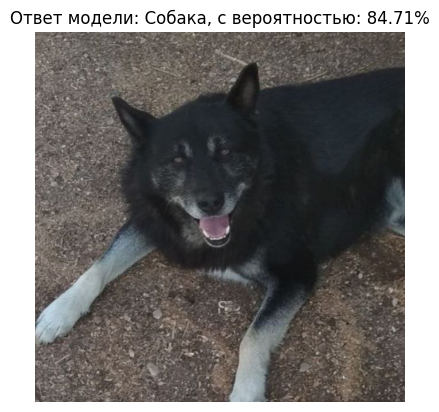

In [291]:
predict_image(image_path_1, model)

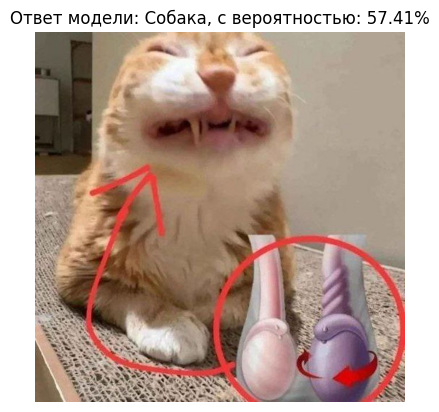

In [292]:
predict_image(image_path_2, model)

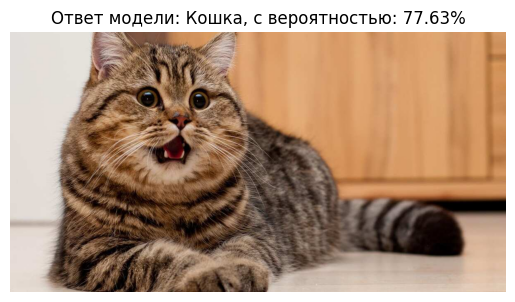

In [293]:
predict_image(image_path_3, model)

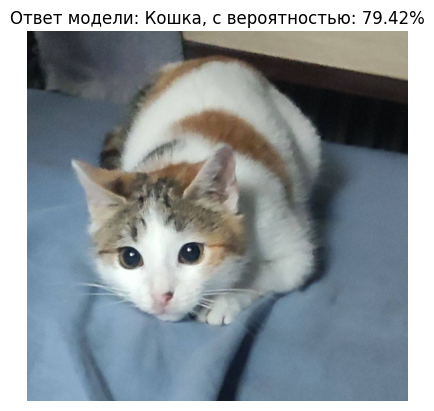

In [299]:
predict_image(image_path_4, model)

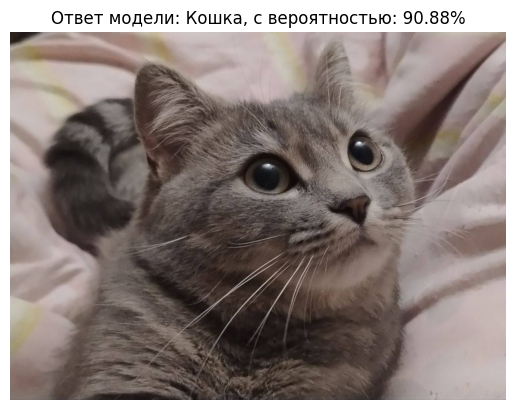

In [295]:
predict_image(image_path_5, model)

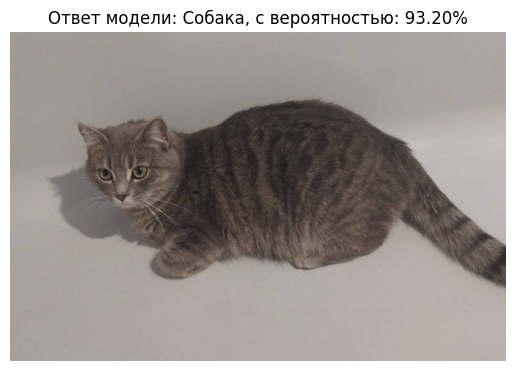

In [296]:
predict_image(image_path_6, model)

In [300]:
image_path_7 = '/content/photo_2025-04-20_22-13-39.jpg'
image_path_8 = '/content/photo_2025-04-20_22-13-42.jpg'
image_path_9 = '/content/photo_2025-04-20_22-13-44.jpg'
image_path_10 = '/content/photo_2025-04-20_22-13-46.jpg'
image_path_11 = '/content/photo_2025-04-20_22-13-49.jpg'
image_path_12 = ''
image_path_13 = ''

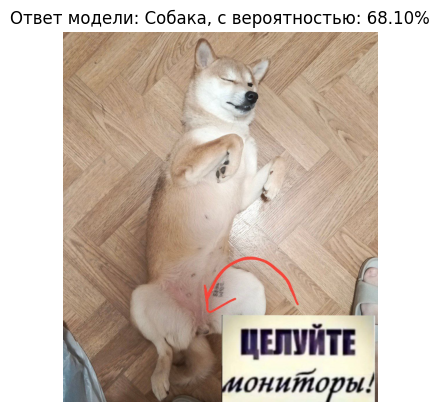

In [301]:
predict_image(image_path_7, model)

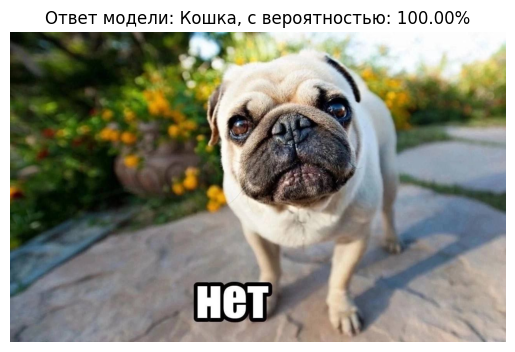

In [302]:
predict_image(image_path_8, model)

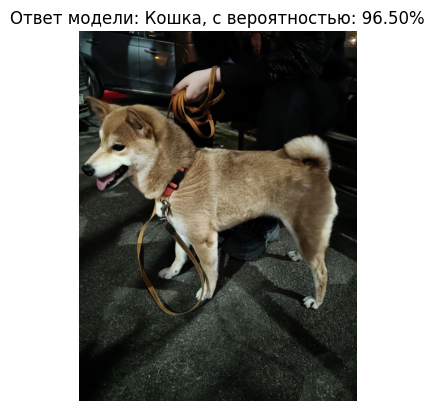

In [303]:
predict_image(image_path_9, model)

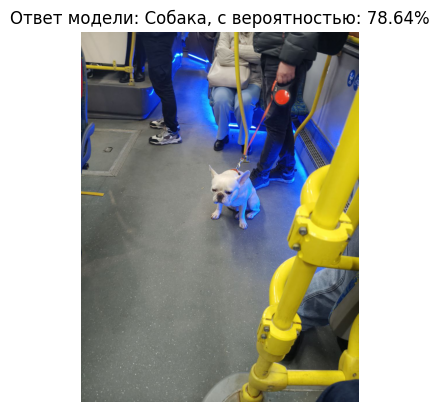

In [304]:
predict_image(image_path_10, model)

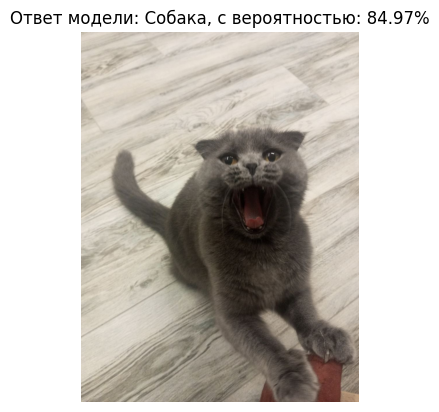

In [305]:
predict_image(image_path_11, model)